# Zensus-Auswertung für die Stadt Trier (Zensus 2022)

In [77]:
# Importiere alle Packages
import fiona
from shapely.geometry import box, shape
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import urllib.parse
import pandas as pd

from pyproj import Transformer

import matplotlib.pyplot as plt
import contextily as ctx
import folium
from folium.plugins import ScrollZoomToggler
import overpy

from branca.colormap import LinearColormap

## Gitterzellen-Daten

Wir laden zunächst die Gitterneztlinien, auf die die Zensusdaten referenziert sind, ein. Einmalig reduzieren wir das Grid des Bundesamtes für Kartographie und Geodäsie auf Trier, damit mein armes Notebook nicht zu viel im Workspace hat.

In [44]:
# Definieren Sie die Bounding Box für Trier

def transform_bbox(bbox, from_crs, to_crs):
    transformer = Transformer.from_crs(from_crs, to_crs, always_xy=True)
    min_x, min_y, max_x, max_y = bbox.bounds
    ll = transformer.transform(min_x, min_y)
    ur = transformer.transform(max_x, max_y)
    return box(ll[0], ll[1], ur[0], ur[1])

trier_bbox_wgs84 = box(6.5, 49.7, 6.8, 49.9)
trier_bbox_laea = transform_bbox(trier_bbox_wgs84, "EPSG:4326", "EPSG:3035")


In [26]:
with fiona.open('DE_Grid_ETRS89-LAEA_100m/geogitter/DE_Grid_ETRS89-LAEA_100m.gpkg', 'r') as source:
    print(source.bounds)
print(trier_bbox_laea.bounds)

(4031300.0, 2684000.0, 4672600.0, 3556600.0)
(4068576.884595167, 2960161.2625864474, 4091152.389394698, 2981399.084611439)


Das 100m Gitternetz für Deutschland (an dem auch die Zensusdaten ausgerichtet sind), sind downloadbar beim Bundesamt für Kartographie und Geodäsie unter https://gdz.bkg.bund.de/index.php/default/inspire/sonstige-inspire-themen/geographische-gitter-fur-deutschland-in-lambert-projektion-geogitter-inspire.html. Der Datensatz ist relativ groß, sodass man ihn nicht in den Arbeitsspeicher eines Notebooks laden kann. Wir filtern daher einmalig das Geogitter auf die Region um Trier:

In [27]:
# Öffne die Quelldatei
with fiona.open('DE_Grid_ETRS89-LAEA_100m/geogitter/DE_Grid_ETRS89-LAEA_100m.gpkg', 'r') as source:
    
    # Erstellen Sie eine gefilterte Kopie
    filtered = filter(lambda f: shape(f['geometry']).intersects(trier_bbox_laea), source)
    
    # Kopiere das Schema
    output_schema = source.schema.copy()
    
    # Schreibe die gefilterten Features in eine neue Datei
    with fiona.open('trier_grid.gpkg', 'w', 
                    driver='GPKG', 
                    crs=source.crs, 
                    schema=output_schema) as output:
        output.writerecords(filtered)


In [2]:
gdf_trier = gpd.read_file('trier_grid.gpkg')

# Nettokaltmiete

Nun laden wir die Daten vom Zensus (https://www.zensus2022.de/DE/Aktuelles/Hinweis_Zensusatlas.html):

In [3]:
nettokaltmiete = pd.read_csv("Tabellen/Zensus2022_Durchschn_Nettokaltmiete_100m-Gitter.csv", delimiter = ";")

In [45]:
print(gdf_trier.head)
print(gdf_trier.x_mp.dtype)

<bound method NDFrame.head of                featuretype_name       dataset_name  OBJECTID  \
0      DE_Grid_ETRS89-LAEA_100m  de_grid_laea_100m   7661278   
1      DE_Grid_ETRS89-LAEA_100m  de_grid_laea_100m   7661279   
2      DE_Grid_ETRS89-LAEA_100m  de_grid_laea_100m   7661280   
3      DE_Grid_ETRS89-LAEA_100m  de_grid_laea_100m   7661281   
4      DE_Grid_ETRS89-LAEA_100m  de_grid_laea_100m   7661282   
...                         ...                ...       ...   
47267  DE_Grid_ETRS89-LAEA_100m  de_grid_laea_100m   7736199   
47268  DE_Grid_ETRS89-LAEA_100m  de_grid_laea_100m   7736200   
47269  DE_Grid_ETRS89-LAEA_100m  de_grid_laea_100m   7736201   
47270  DE_Grid_ETRS89-LAEA_100m  de_grid_laea_100m   7736202   
47271  DE_Grid_ETRS89-LAEA_100m  de_grid_laea_100m   7736203   

                     id       x_sw       y_sw       x_mp       y_mp  f_staat  \
0      100mN29601E40685  4068500.0  2960100.0  4068550.0  2960150.0  10000.0   
1      100mN29601E40686  4068600.0  29601

In [4]:
nettokaltmiete.GITTER_ID_100m

0          CRS3035RES100mN2691700E4341100
1          CRS3035RES100mN2692400E4341200
2          CRS3035RES100mN2694800E4343900
3          CRS3035RES100mN2696700E4341400
4          CRS3035RES100mN2697400E4342400
                        ...              
1287337    CRS3035RES100mN3547400E4220200
1287338    CRS3035RES100mN3547500E4219900
1287339    CRS3035RES100mN3547500E4220000
1287340    CRS3035RES100mN3547500E4220100
1287341    CRS3035RES100mN3547600E4219900
Name: GITTER_ID_100m, Length: 1287342, dtype: object

In [5]:
# Umwandeln in floats, damit wir mergen können
nettokaltmiete.x_mp_100m = nettokaltmiete.x_mp_100m.astype(np.float64)
nettokaltmiete.y_mp_100m = nettokaltmiete.y_mp_100m.astype(np.float64)

In [18]:
kaltmieteImGrid =  gdf_trier.merge(nettokaltmiete, left_on=["x_mp", "y_mp"], right_on=["x_mp_100m", "y_mp_100m"]) # Daten mit Gitternetz verbinden
print(kaltmieteImGrid.shape)
print(kaltmieteImGrid.columns)
print(kaltmieteImGrid.durchschnMieteQM.min(), kaltmieteImGrid.durchschnMieteQM.max())

(2964, 23)
Index(['featuretype_name', 'dataset_name', 'OBJECTID', 'id', 'x_sw', 'y_sw',
       'x_mp', 'y_mp', 'f_staat', 'f_land', 'f_wasser', 'p_staat', 'p_land',
       'p_wasser', 'Shape_Length', 'Shape_Area', 'ags', 'geometry',
       'GITTER_ID_100m', 'x_mp_100m', 'y_mp_100m', 'durchschnMieteQM',
       'werterlaeuternde_Zeichen'],
      dtype='object')
10,00 9,99


In [28]:
print(kaltmieteImGrid.durchschnMieteQM.apply(lambda x: x == ".").sum())
print(kaltmieteImGrid.durchschnMieteQM.apply(lambda x: x.startswith("(")).sum())
kaltmieteImGrid.durchschnMieteQM = kaltmieteImGrid.durchschnMieteQM.apply(lambda x: np.float32(x.replace(",", ".")))

In [31]:
print( kaltmieteImGrid.durchschnMieteQM.min(), kaltmieteImGrid.durchschnMieteQM.max() ) 

2.05 39.81


Die Histogramm-Auswertung ist hier statistisch nicht korrekt, da Gitterzellen mit wenig Erhebungseinheiten überrepräsentiert werden, gibt aber ein Gefühl für die Daten.

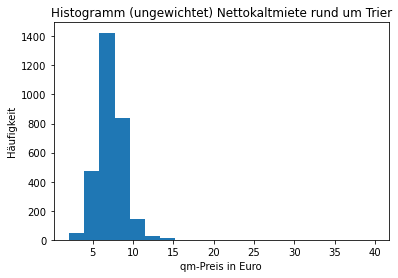

In [37]:
plt.hist(kaltmieteImGrid["durchschnMieteQM"], bins=20)
plt.title("Histogramm (ungewichtet) Nettokaltmiete rund um Trier")
plt.xlabel("qm-Preis in Euro")
plt.ylabel("Häufigkeit")
plt.show()

Wir bauen nun eine Karte mit den Nettokaltmieten je QM (diese ist dann nicht mehr verzerrt im Gegensatz zum Histogramm).

In [85]:
m = folium.Map(
    location=[kaltmieteImGrid.centroid.y.mean(), kaltmieteImGrid.centroid.x.mean()],
    zoom_start=12,
    max_zoom=18,  # Maximaler Zoom-Level
    zoom_control=True  # Zoom-Steuerelemente anzeigen
)
ScrollZoomToggler().add_to(m)

# Grenzen für die Karte
m.fit_bounds([
    [49.70, 6.55],  # Südwestliche Ecke
    [49.80, 6.73]   # Nordöstliche Ecke
])


In [86]:
# Farbskala für Kaltmieten erstellen
colormap = LinearColormap(colors=['yellow', 'orange', 'red'], 
                          vmin=kaltmieteImGrid['durchschnMieteQM'].min(), 
                          vmax=kaltmieteImGrid['durchschnMieteQM'].max())

# Kaltmieten als Choropleth hinzufügen
folium.GeoJson(
    kaltmieteImGrid,
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['durchschnMieteQM']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(fields=['durchschnMieteQM'], 
                                  aliases=['Nettokaltmiete: '],
                                  localize=True)
).add_to(m)

# Farbskala zur Karte hinzufügen
colormap.add_to(m)

Wir fügen zu der Karte Infrastruktur-Daten hinzu, um mögliche Korrelationen zu entdecken.

In [62]:
# Lade Infrastrukturdaten
api = overpy.Overpass()


# Definieren Sie die Bounding Box für Trier
bbox = f"{trier_bbox_wgs84.bounds[1]},{trier_bbox_wgs84.bounds[0]},{trier_bbox_wgs84.bounds[3]},{trier_bbox_wgs84.bounds[2]}"

# Abfrage für Infrastruktur mit expliziter Anforderung der Nodes
query = f"""
[out:json];
(
  node["railway"="station"]({bbox});
  way["amenity"="school"]({bbox});
  way["amenity"="university"]({bbox});
  >;  // Dies fügt alle Nodes hinzu, die zu den Ways gehören
);
out body;
"""
print(query)
result = api.query(query)


[out:json];
(
  node["railway"="station"](49.7,6.5,49.9,6.8);
  way["amenity"="school"](49.7,6.5,49.9,6.8);
  way["amenity"="university"](49.7,6.5,49.9,6.8);
  >;  // Dies fügt alle Nodes hinzu, die zu den Ways gehören
);
out body;



In [87]:
bahnhof_layer = folium.FeatureGroup(name="Bahnhöfe", show=False)
schule_layer = folium.FeatureGroup(name="Schulen", show=False)
uni_layer = folium.FeatureGroup(name="Hochschulen", show=False)

def calculate_center(way):
    try:
        nodes = way.get_nodes(resolve_missing=True)
        if nodes:
            lats = [float(node.lat) for node in nodes]
            lons = [float(node.lon) for node in nodes]
            return np.mean(lats), np.mean(lons)
    except overpy.exception.DataIncomplete:
        print(f"Warnung: Konnte Mittelpunkt für Way {way.id} nicht berechnen")
    return None

for node in result.nodes:
    if node.tags.get("railway") == "station":
        folium.Marker(
            [node.lat, node.lon],
            popup=node.tags.get("name", "Unbenannt"),
            icon=folium.Icon(color="red", icon="train")
        ).add_to(bahnhof_layer)

for way in result.ways:
    center_lat, center_lon = calculate_center(way)
    if way.tags.get("amenity") == "school":
        folium.Marker(
            [center_lat, center_lon],
            popup=way.tags.get("name", "Unbenannt"),
            icon=folium.Icon(color="green", icon="graduation-cap")
        ).add_to(schule_layer)
    elif way.tags.get("amenity") == "university":
        folium.Marker(
            [center_lat, center_lon],
            popup=way.tags.get("name", "Unbenannt"),
            icon=folium.Icon(color="purple", icon="university")
        ).add_to(uni_layer)

# Fügen Sie die Layer zur Karte hinzu
bahnhof_layer.add_to(m)
schule_layer.add_to(m)
uni_layer.add_to(m)

folium.LayerControl().add_to(m)


In [88]:
m

# Vergleich mit der Wohnraumbedarfsanalyse

Die Wohnraumbedarfsanalyse findet sich unter https://stadtentwicklungtrier.wordpress.com/wp-content/uploads/2022/07/gewos_2022-wohnraumbedarfsanalyse-fuer-die-stadt-trier.pdf 